In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
# import ecoscape_connectivity
from scgt import Tile, GeoTiff
import numpy as np
import torch
import rasterio

DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "paper_repro/habitat.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "paper_repro/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "paper_repro/restored_terrain.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")
transmission_d = util.read_transmission_csv(PERMEABILITY_PATH)

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "paper_repro/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "paper_repro/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "paper_repro/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "paper_repro/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "paper_repro/death.tif")

optimizer = restorationOptimizer(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 100)
optimizer.randomize_transmission_dict()
transmission_d = optimizer.permeability_dict
print(transmission_d)

In [ ]:
# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (3,3)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1
setup_mpl()

Restoration based on highest death rates:
1. Compute connectivity with pre-determined seeds
2. Compute death layer by taking (flow/p) * (1-p)
3. Find top n pixels with highest death rates
4. Convert pixels to more permiable terrain

In [ ]:
# Pre-set seeds for determinism...
hab = GeoTiff.from_file(optimizer.habitat_fn)
hab_tile = hab.get_all_as_tile().m.astype(np.float)
seeds = (torch.rand(400,*(hab_tile.shape)) < 0.002) * hab_tile # 1% of pixels are seeds.

In [4]:
# compute connectivity - not needed unless output is needed
repopulation.compute_connectivity(HABITAT_PATH, TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, transmission_d, single_tile=True)
pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [23]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif)

print(f'Pre-restoration sum of connectivity {pre_restoration_conn}')

pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)
optimizer.restore_pixels()

# compute connectivity w/ restored terrain
repopulation.compute_connectivity(HABITAT_PATH, RESTORED_TERRAIN_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, transmission_d, single_tile=True)
post_restoration_conn = optimizer.sum_of_tif(RESTORED_CONNECTIVITY_PATH)
print(f'Post-restoration sum of connectivity {post_restoration_conn}')

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


changing n
Pre-restoration sum of connectivity 174176641


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


changing n


KeyboardInterrupt: 

Compare new (post-restoration) connectivity to old connectivity
    - Use same seeds to enforce determinism

In [4]:
# change in connectivity:
delta_conn = int(post_restoration_conn) - int(pre_restoration_conn)
percent_change = delta_conn / pre_restoration_conn

print(f'pre-restoration sum of connectivity {pre_restoration_conn}')
print(f'post-restoration sum of connectivity {post_restoration_conn}')
print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

pre-restoration sum of connectivity 3393799
post-restoration sum of connectivity 3395963
change in connectivity: 2164, or 0.0006376%


Try to compute regional connectivity gain for each restored pixel...

In [24]:
PRE_TER = os.path.join(DATA_PATH, "paper_repro/pre_ter.tif")
PRE_HAB = os.path.join(DATA_PATH, "paper_repro/pre_hab.tif")
PRE_CONN = os.path.join(DATA_PATH, "paper_repro/pre_conn.tif")
PRE_FLOW = os.path.join(DATA_PATH, "paper_repro/pre_flow.tif")
POST_TER = os.path.join(DATA_PATH, "paper_repro/post_ter.tif")
POST_HAB = os.path.join(DATA_PATH, "paper_repro/post_hab.tif")
POST_CONN = os.path.join(DATA_PATH, "paper_repro/post_conn.tif")
POST_FLOW = os.path.join(DATA_PATH, "paper_repro/post_flow.tif")

In [25]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_death = optimizer.get_highest_death_pixels(death_tif, n=100)
print(highest_death)

ter = GeoTiff.from_file(optimizer.terrain_fn)
restored_ter = GeoTiff.from_file(optimizer.restored_terr_fn)
hab = GeoTiff.from_file(optimizer.habitat_fn)

window_sz = 16

total_delta_connectivity = 0
total_percent_change = 0.0

permeabilities = []
deaths = []
change_percents = []

for i, (x, y) in enumerate(highest_death.keys()):
    deaths.append(highest_death[(x, y)])
    lat_max, lon_max = rasterio.transform.xy(ter.dataset.transform, y-window_sz, x-window_sz)
    lat_min, lon_min = rasterio.transform.xy(ter.dataset.transform, y+window_sz, x+window_sz)

    pre_ter = ter.crop_to_new_file(PRE_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # pre_ter.draw_geotiff()
    pre_ter.dataset.close()

    pre_hab = hab.crop_to_new_file(PRE_HAB, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # hab_tile = hab.get_all_as_tile().m.astype(np.float)
    # pre_hab.draw_geotiff()
    pre_hab.dataset.close()

    # seed = torch.randint(1, 1000, (1,))[0]
    # seed = i
    repopulation.compute_connectivity(PRE_HAB, PRE_TER, PRE_CONN, PRE_FLOW, transmission_d, single_tile=True, num_simulations=5000)

    # conn_before = GeoTiff.from_file(PRE_CONN)
    # conn_before_tile = conn_before.get_all_as_tile()
    # conn_before.draw_geotiff()

    pre_conn_sum = optimizer.sum_of_tif(PRE_CONN)

    with GeoTiff.from_file(optimizer.terrain_fn) as terrain_geotiff:
        old_terrain = terrain_geotiff.get_pixel_value(x, y)
        permeabilities.append(optimizer.permeability_dict[old_terrain])

    optimizer.change_terrain(x, y, verbose=True)
    post_ter = restored_ter.crop_to_new_file(POST_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # post_ter.draw_geotiff()
    post_ter.dataset.close()

    repopulation.compute_connectivity(PRE_HAB, POST_TER, POST_CONN, POST_FLOW, transmission_d, single_tile=True, num_simulations=5000)
    # conn_after = GeoTiff.from_file(POST_CONN)
    # conn_after.draw_geotiff()
    # conn_after_tile = conn_after.get_all_as_tile()
    post_conn_sum = optimizer.sum_of_tif(POST_CONN)
    
    # change in connectivity:
    delta_conn = int(post_conn_sum) - int(pre_conn_sum)
    percent_change = delta_conn / pre_conn_sum

    change_percents.append(percent_change)

    total_delta_connectivity += delta_conn
    total_percent_change += percent_change

    # diff_tile = Tile(conn_after_tile.w, conn_after_tile.h, conn_after_tile.b, conn_after_tile.c, conn_after_tile.x, conn_after_tile.y, conn_after_tile.m-conn_before_tile.m)
    # diff_tile.draw_tile()

    print(f'pre-restoration sum of connectivity {pre_conn_sum}')
    print(f'post-restoration sum of connectivity {post_conn_sum}')
    print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / len(highest_death.keys())}")



ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(1161, 3335): 70, (862, 2169): 57, (859, 2160): 56, (864, 2172): 56, (864, 2173): 56, (995, 1861): 55, (864, 2174): 55, (852, 2134): 55, (993, 1858): 55, (1972, 4093): 55, (862, 2168): 54, (2214, 4008): 54, (992, 1858): 54, (2212, 4006): 54, (1975, 4093): 54, (991, 1855): 54, (863, 2170): 54, (947, 2265): 54, (991, 1856): 54, (1441, 2115): 54, (864, 2176): 53, (954, 2257): 53, (992, 1854): 53, (1007, 1869): 53, (1970, 4092): 53, (863, 2174): 53, (1205, 1296): 53, (864, 2171): 53, (865, 2173): 53, (863, 2173): 53, (1971, 4092): 53, (864, 2175): 53, (849, 2131): 53, (865, 2176): 53, (1272, 1253): 52, (1393, 553): 52, (866, 2179): 52, (991, 1862): 52, (866, 2178): 52, (1010, 2256): 52, (1009, 1889): 52, (848, 2132): 52, (866, 2177): 52, (1272, 1255): 52, (2363, 5327): 51, (2211, 4006): 51, (2209, 4006): 51, (863, 2171): 51, (937, 2286): 51, (2212, 4007): 51, (1272, 1254): 51, (1089, 2079): 51, (848, 2130): 51, (865, 2174): 51, (1973, 4093): 51, (1975, 4094): 51, (2192, 4879): 51, (1976, 

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1161, 3335) from permiability 0.0009343065693430657 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 16296
post-restoration sum of connectivity 17086
change in connectivity: 790, or 0.0484782%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (862, 2169) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 37383
post-restoration sum of connectivity 37092
change in connectivity: -291, or -0.0077843%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (859, 2160) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 18555
post-restoration sum of connectivity 18529
change in connectivity: -26, or -0.0014012%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2172) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 50606
post-restoration sum of connectivity 51390
change in connectivity: 784, or 0.0154922%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2173) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 53005
post-restoration sum of connectivity 53165
change in connectivity: 160, or 0.0030186%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (995, 1861) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 34019
post-restoration sum of connectivity 34318
change in connectivity: 299, or 0.0087892%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2174) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 58358
post-restoration sum of connectivity 57675
change in connectivity: -683, or -0.0117036%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (852, 2134) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 11871
post-restoration sum of connectivity 11515
change in connectivity: -356, or -0.029989%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (993, 1858) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 42852
post-restoration sum of connectivity 42541
change in connectivity: -311, or -0.0072575%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1972, 4093) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 6025
post-restoration sum of connectivity 8008
change in connectivity: 1983, or 0.3291286%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (862, 2168) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 32533
post-restoration sum of connectivity 33495
change in connectivity: 962, or 0.02957%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2214, 4008) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 93178
post-restoration sum of connectivity 92729
change in connectivity: -449, or -0.0048187%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (992, 1858) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 42536
post-restoration sum of connectivity 41870
change in connectivity: -666, or -0.0156573%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2212, 4006) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 93197
post-restoration sum of connectivity 94675
change in connectivity: 1478, or 0.0158589%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1975, 4093) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5377
post-restoration sum of connectivity 7735
change in connectivity: 2358, or 0.4385345%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1855) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 45856
post-restoration sum of connectivity 46989
change in connectivity: 1133, or 0.0247078%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (863, 2170) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 43644
post-restoration sum of connectivity 42341
change in connectivity: -1303, or -0.0298552%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (947, 2265) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 25390
post-restoration sum of connectivity 26131
change in connectivity: 741, or 0.0291847%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1856) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 45314
post-restoration sum of connectivity 44665
change in connectivity: -649, or -0.0143223%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1441, 2115) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 84219
post-restoration sum of connectivity 84124
change in connectivity: -95, or -0.001128%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2176) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 68449
post-restoration sum of connectivity 68814
change in connectivity: 365, or 0.0053324%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (954, 2257) from permiability 0.01454014598540146 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 25594
post-restoration sum of connectivity 26053
change in connectivity: 459, or 0.0179339%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (992, 1854) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 50162
post-restoration sum of connectivity 49250
change in connectivity: -912, or -0.0181811%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1007, 1869) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 45470
post-restoration sum of connectivity 45769
change in connectivity: 299, or 0.0065758%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1970, 4092) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 6281
post-restoration sum of connectivity 7972
change in connectivity: 1691, or 0.2692246%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (863, 2174) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 55344
post-restoration sum of connectivity 56063
change in connectivity: 719, or 0.0129915%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1205, 1296) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 125336
post-restoration sum of connectivity 126361
change in connectivity: 1025, or 0.008178%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2171) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 47252
post-restoration sum of connectivity 48572
change in connectivity: 1320, or 0.0279353%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (865, 2173) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 56077
post-restoration sum of connectivity 56518
change in connectivity: 441, or 0.0078642%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (863, 2173) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 52057
post-restoration sum of connectivity 51956
change in connectivity: -101, or -0.0019402%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1971, 4092) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 6229
post-restoration sum of connectivity 7757
change in connectivity: 1528, or 0.2453042%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (864, 2175) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 63843
post-restoration sum of connectivity 64066
change in connectivity: 223, or 0.0034929%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (849, 2131) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 7626
post-restoration sum of connectivity 7436
change in connectivity: -190, or -0.0249148%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (865, 2176) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 69929
post-restoration sum of connectivity 71137
change in connectivity: 1208, or 0.0172747%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1272, 1253) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 51631
post-restoration sum of connectivity 56329
change in connectivity: 4698, or 0.0909918%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1393, 553) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 99950
post-restoration sum of connectivity 98621
change in connectivity: -1329, or -0.0132966%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (866, 2179) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 89814
post-restoration sum of connectivity 87971
change in connectivity: -1843, or -0.0205202%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1862) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 34701
post-restoration sum of connectivity 35235
change in connectivity: 534, or 0.0153886%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (866, 2178) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 83593
post-restoration sum of connectivity 83086
change in connectivity: -507, or -0.0060651%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1010, 2256) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 4593
post-restoration sum of connectivity 4607
change in connectivity: 14, or 0.0030481%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1009, 1889) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 58294
post-restoration sum of connectivity 58116
change in connectivity: -178, or -0.0030535%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (848, 2132) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5908
post-restoration sum of connectivity 6154
change in connectivity: 246, or 0.0416385%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (866, 2177) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 77325
post-restoration sum of connectivity 76403
change in connectivity: -922, or -0.0119237%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1272, 1255) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 44860
post-restoration sum of connectivity 47776
change in connectivity: 2916, or 0.0650022%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2363, 5327) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 28072
post-restoration sum of connectivity 28308
change in connectivity: 236, or 0.008407%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2211, 4006) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 97979
post-restoration sum of connectivity 97872
change in connectivity: -107, or -0.0010921%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2209, 4006) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 107557
post-restoration sum of connectivity 108187
change in connectivity: 630, or 0.0058574%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (863, 2171) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 44789
post-restoration sum of connectivity 44238
change in connectivity: -551, or -0.0123021%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (937, 2286) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 71043
post-restoration sum of connectivity 69205
change in connectivity: -1838, or -0.0258717%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2212, 4007) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 97616
post-restoration sum of connectivity 97104
change in connectivity: -512, or -0.005245%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1272, 1254) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 47873
post-restoration sum of connectivity 51901
change in connectivity: 4028, or 0.0841393%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1089, 2079) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 98361
post-restoration sum of connectivity 100369
change in connectivity: 2008, or 0.0204146%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (848, 2130) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 6812
post-restoration sum of connectivity 6739
change in connectivity: -73, or -0.0107164%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (865, 2174) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 59810
post-restoration sum of connectivity 59923
change in connectivity: 113, or 0.0018893%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1973, 4093) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5934
post-restoration sum of connectivity 7984
change in connectivity: 2050, or 0.3454668%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1975, 4094) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5697
post-restoration sum of connectivity 7520
change in connectivity: 1823, or 0.319993%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2192, 4879) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 39721
post-restoration sum of connectivity 39434
change in connectivity: -287, or -0.0072254%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1976, 4093) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5596
post-restoration sum of connectivity 6853
change in connectivity: 1257, or 0.2246247%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1974, 4093) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5740
post-restoration sum of connectivity 8134
change in connectivity: 2394, or 0.4170732%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1090, 2079) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 99172
post-restoration sum of connectivity 101325
change in connectivity: 2153, or 0.0217098%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1863) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 34986
post-restoration sum of connectivity 34121
change in connectivity: -865, or -0.0247242%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (849, 2132) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 7186
post-restoration sum of connectivity 7402
change in connectivity: 216, or 0.0300584%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1269, 1266) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 47088
post-restoration sum of connectivity 48186
change in connectivity: 1098, or 0.023318%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1861) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 36466
post-restoration sum of connectivity 36314
change in connectivity: -152, or -0.0041683%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2196, 4877) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 38335
post-restoration sum of connectivity 39082
change in connectivity: 747, or 0.0194861%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2206, 4007) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 123151
post-restoration sum of connectivity 122602
change in connectivity: -549, or -0.0044579%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2208, 4007) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 115330
post-restoration sum of connectivity 113729
change in connectivity: -1601, or -0.0138819%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2388, 5297) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 22963
post-restoration sum of connectivity 23546
change in connectivity: 583, or 0.0253887%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2234, 5030) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 74776
post-restoration sum of connectivity 73754
change in connectivity: -1022, or -0.0136675%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2208, 4006) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 111040
post-restoration sum of connectivity 110794
change in connectivity: -246, or -0.0022154%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (849, 2130) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 7583
post-restoration sum of connectivity 7952
change in connectivity: 369, or 0.0486615%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2197, 4877) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 36043
post-restoration sum of connectivity 35592
change in connectivity: -451, or -0.0125128%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (865, 2175) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 65101
post-restoration sum of connectivity 65667
change in connectivity: 566, or 0.0086942%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1274, 1264) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 49418
post-restoration sum of connectivity 53824
change in connectivity: 4406, or 0.0891578%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (991, 1854) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 48049
post-restoration sum of connectivity 47930
change in connectivity: -119, or -0.0024766%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2350, 5208) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 59198
post-restoration sum of connectivity 58613
change in connectivity: -585, or -0.0098821%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1210, 1305) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 141498
post-restoration sum of connectivity 143601
change in connectivity: 2103, or 0.0148624%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1268, 1265) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 41743
post-restoration sum of connectivity 44900
change in connectivity: 3157, or 0.0756294%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2193, 4968) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 29900
post-restoration sum of connectivity 30457
change in connectivity: 557, or 0.0186288%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1007, 2657) from permiability 0.01454014598540146 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 39075
post-restoration sum of connectivity 39014
change in connectivity: -61, or -0.0015611%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (3454, 3464) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 34604
post-restoration sum of connectivity 34935
change in connectivity: 331, or 0.0095654%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2363, 5326) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 28281
post-restoration sum of connectivity 27290
change in connectivity: -991, or -0.0350412%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2347, 5275) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 102040
post-restoration sum of connectivity 102134
change in connectivity: 94, or 0.0009212%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (865, 2179) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 87143
post-restoration sum of connectivity 86224
change in connectivity: -919, or -0.0105459%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (3630, 3105) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 10192
post-restoration sum of connectivity 10697
change in connectivity: 505, or 0.0495487%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (847, 2124) from permiability 0.031532846715328466 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 7226
post-restoration sum of connectivity 7262
change in connectivity: 36, or 0.004982%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (1976, 4094) from permiability 0.03351824817518248 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 5449
post-restoration sum of connectivity 7138
change in connectivity: 1689, or 0.3099651%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2350, 5207) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 58013
post-restoration sum of connectivity 57157
change in connectivity: -856, or -0.0147553%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (3693, 3436) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 16380
post-restoration sum of connectivity 16634
change in connectivity: 254, or 0.0155067%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2191, 4879) from permiability 0.09874452554744526 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 41744
post-restoration sum of connectivity 41667
change in connectivity: -77, or -0.0018446%


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (2210, 4006) from permiability 0.04525547445255475 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
More than 1000 errors or warnings have been reported. No more will be reported from now.


pre-restoration sum of connectivity 102175
post-restoration sum of connectivity 103495
change in connectivity: 1320, or 0.012919%
Restoring pixel (2362, 5327) from permiability 0.09874452554744526 to 1.0
pre-restoration sum of connectivity 24696
post-restoration sum of connectivity 24581
change in connectivity: -115, or -0.0046566%
Restoring pixel (2195, 4968) from permiability 0.09874452554744526 to 1.0
pre-restoration sum of connectivity 29824
post-restoration sum of connectivity 29497
change in connectivity: -327, or -0.0109643%
Restoring pixel (2137, 3990) from permiability 0.04525547445255475 to 1.0
pre-restoration sum of connectivity 154805
post-restoration sum of connectivity 153975
change in connectivity: -830, or -0.0053616%
Restoring pixel (2206, 4008) from permiability 0.04525547445255475 to 1.0
pre-restoration sum of connectivity 129113
post-restoration sum of connectivity 128950
change in connectivity: -163, or -0.0012625%
Restoring pixel (2350, 5209) from permiability 0.0

[70, 57, 56, 56, 56, 55, 55, 55, 55, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]
[0.04847815414825724, -0.007784286975363133, -0.0014012395580706009, 0.015492234122436074, 0.00301858315253278, 0.008789206031923336, -0.01170362246821344, -0.029989048942801785, -0.0072575375711752075, 0.32912863070539417, 0.029569975102203917, -0.004818734035931228, -0.01565732555952605, 0.015858879577668808, 0.4385344987911475, 0.02470778087927425, -0.029855192008065256, 0.029184718393068135, -0.014322284503685395, -0.001128011493843432, 0.0053324372890765385, 0.017933890755645856, -0.018181093257844585, 0.006575764240158346, 0.2692246457570451, 0.012991471523561723, 0.008178017488989596, 

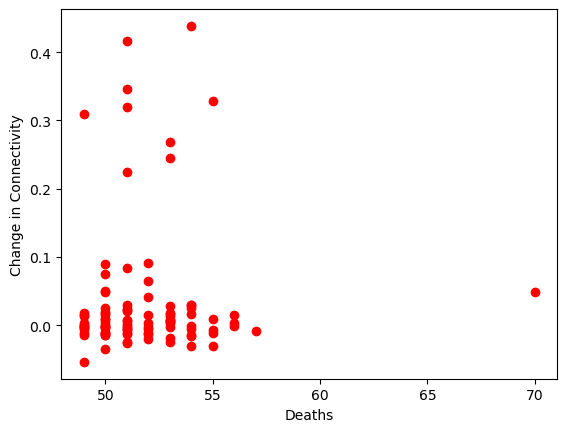

In [26]:
print(deaths)
print(change_percents)
plt.scatter(deaths, change_percents, color="red")
plt.xlabel("Deaths")
plt.ylabel("Change in Connectivity")
plt.show()

In [27]:
print(np.corrcoef(deaths, change_percents))

[[1.        0.0515809]
 [0.0515809 1.       ]]


In [28]:
death_sum = 0
for i in highest_death.values():
    death_sum += i

print(f"death_sum: {death_sum}")

print(f"Connectivity change per unit death: {total_delta_connectivity/death_sum}")


death_sum: 5178
Connectivity change per unit death: 7.7701815372730785


About 7x more connectivity units per potential unit

TODO:
- Make mechanism for determinism

In [29]:
# compute connectivity w/ restored terrain
repopulation.compute_connectivity(HABITAT_PATH, RESTORED_TERRAIN_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, transmission_d, single_tile=True)
post_restoration_conn = optimizer.sum_of_tif(RESTORED_CONNECTIVITY_PATH)
print(f'Pre-restoration sum of connectivity {pre_restoration_conn}')
print(f'Post-restoration sum of connectivity {post_restoration_conn}')

Pre-restoration sum of connectivity 174176641
Post-restoration sum of connectivity 174154920


In [21]:
print(f"Change in connectivity: {post_restoration_conn-pre_restoration_conn}")

Change in connectivity: 11122
